In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
import ast
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import seaborn as sns

SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# Boxplots of parameter values in LCs

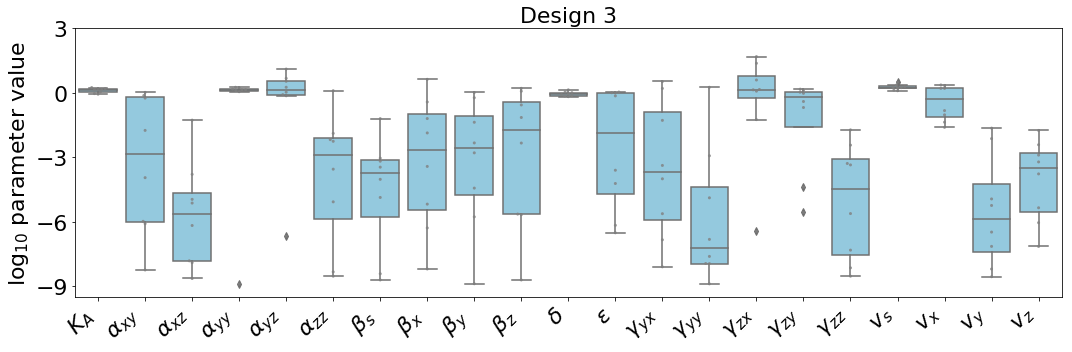

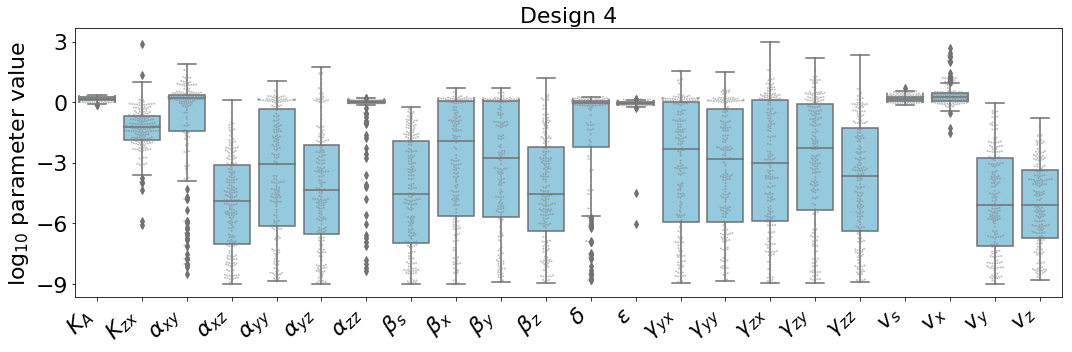

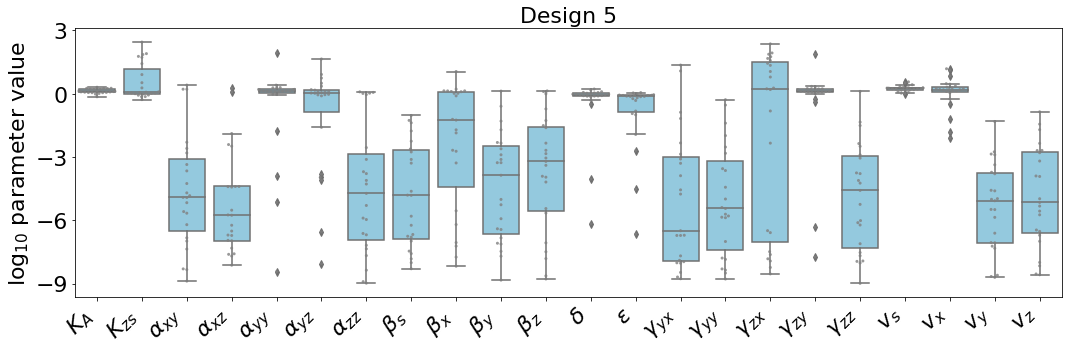

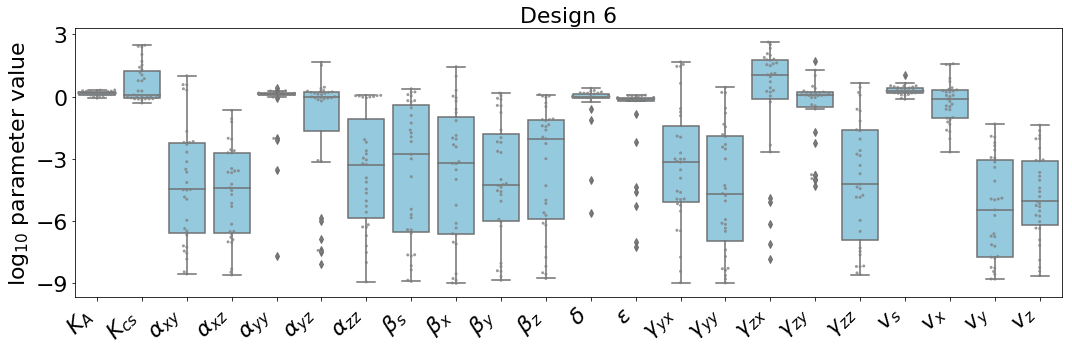

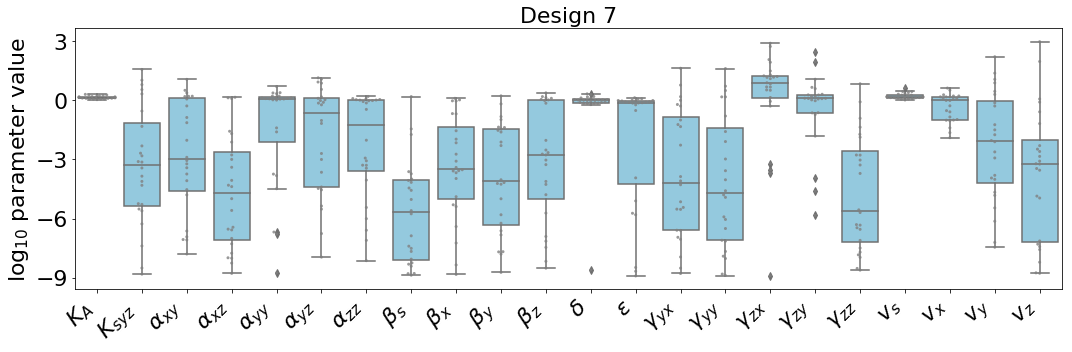

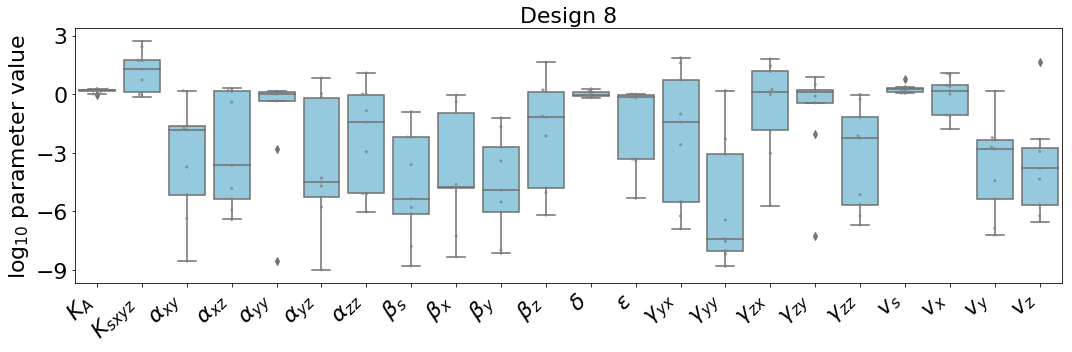

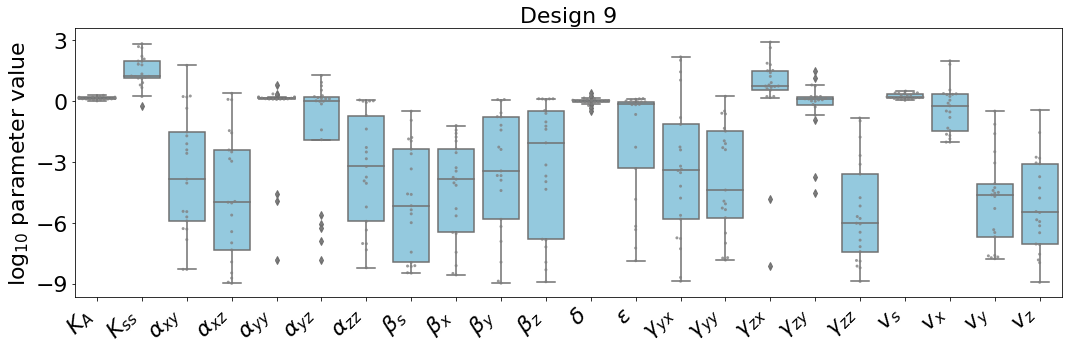

In [3]:
model_list = ['Design 3','Design 4','Design 5','Design 6','Design 7','Design 8','Design 9']

pnames = {}

all_pvals = {} # will contain pvals_model (below) for each model

df = pd.DataFrame()
for j, model in enumerate(model_list):
    
    pvals_model = {}
    
    path = '../LCs/'+model+'/LC_parameters'
    df_LC = pd.read_pickle(path)
    
    # require correct peak sequence
    df_LC = df_LC[df_LC['Peak sequence'].isin(['s, x, y, z','x, y, z, s', 'y, z, s, x', 'z, s, x, y'])]
    
    if len(df_LC)>0:
        df_LC = df_LC.apply(lambda x: dict(x['Parameters']),axis=1)
        
        for i, row in enumerate(df_LC):
            for k in row.keys():
                if k in pvals_model:
                    pvals_model[k].append(row[k])
                else:
                    pvals_model[k] = [row[k]]
    
    # save a list of sorted parameter names for design 3-9
    pnames[model] = [k for k in sorted(pvals_model)]
    
    all_pvals[model] = pvals_model

    fig = plt.figure(figsize=(15,5))

    ax = sns.boxplot(data=[np.log10(pvals_model[k]) for k in sorted(pvals_model)],color='skyblue')
    
    if j==1:
        a = 0.5
        s = 2
    else:
        a = 0.8
        s = 3
    
    ax = sns.swarmplot(data=[np.log10(pvals_model[k]) for k in sorted(pvals_model)], color="gray", size=s, alpha=a)
    
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    fig.gca().set_xticklabels([r'$' + s.replace('_','_{').replace('e','\\epsilon').replace('a','\\alpha').replace('g','\\gamma').replace('b','\\beta').replace('d','\\delta') + '}$' for s in sorted(pvals_model.keys())])
    fig.gca().set_ylabel(r'$\log_{10}$ parameter value', fontsize=22)
    fig.gca().set_yticks([-9, -6, -3, 0, 3])
    fig.gca().set_title(model)
    
    plt.tight_layout()
    fig.savefig('../Figures/Supp_LC_properties/'+model.replace(' ','_')+'.pdf')
    plt.show()

# Correlation analysis of parameter values

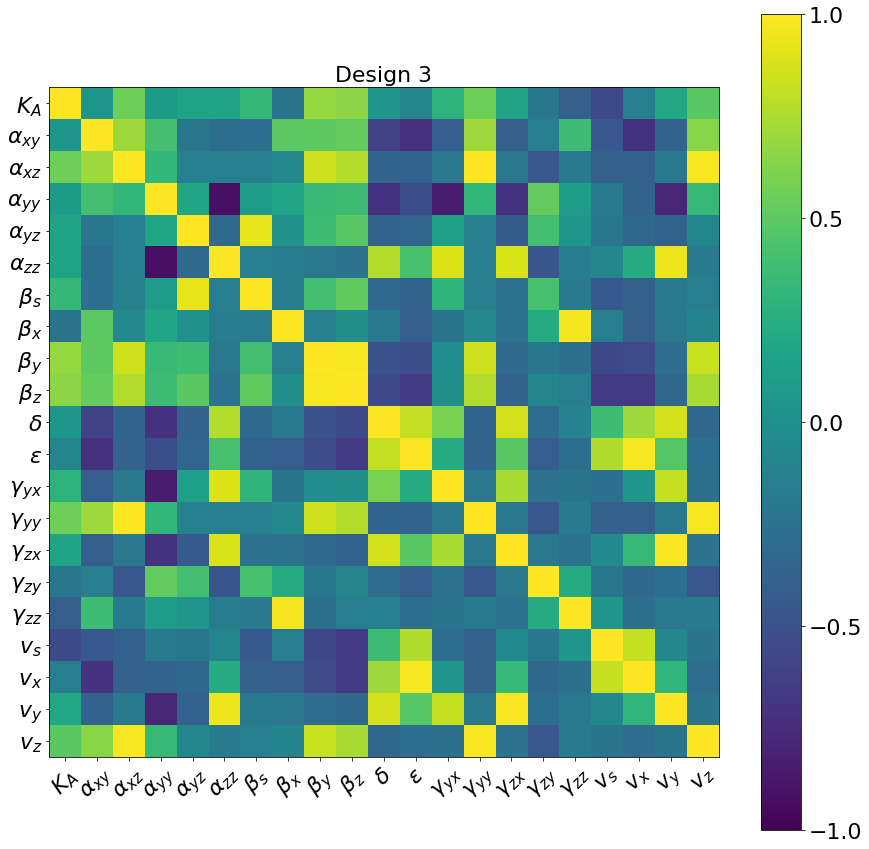

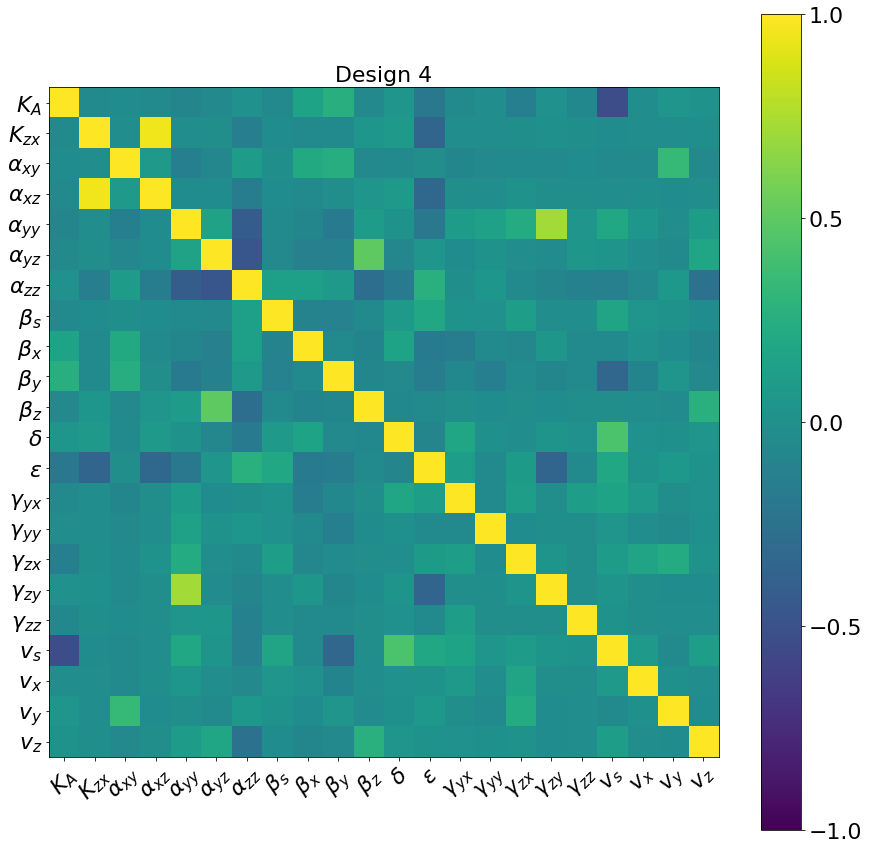

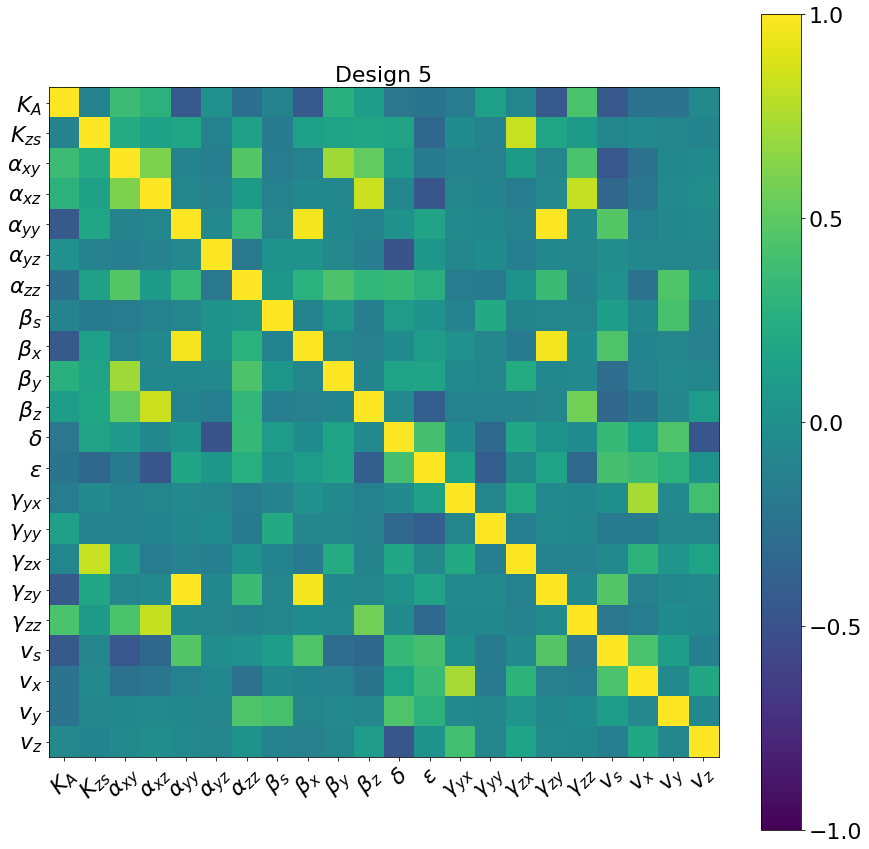

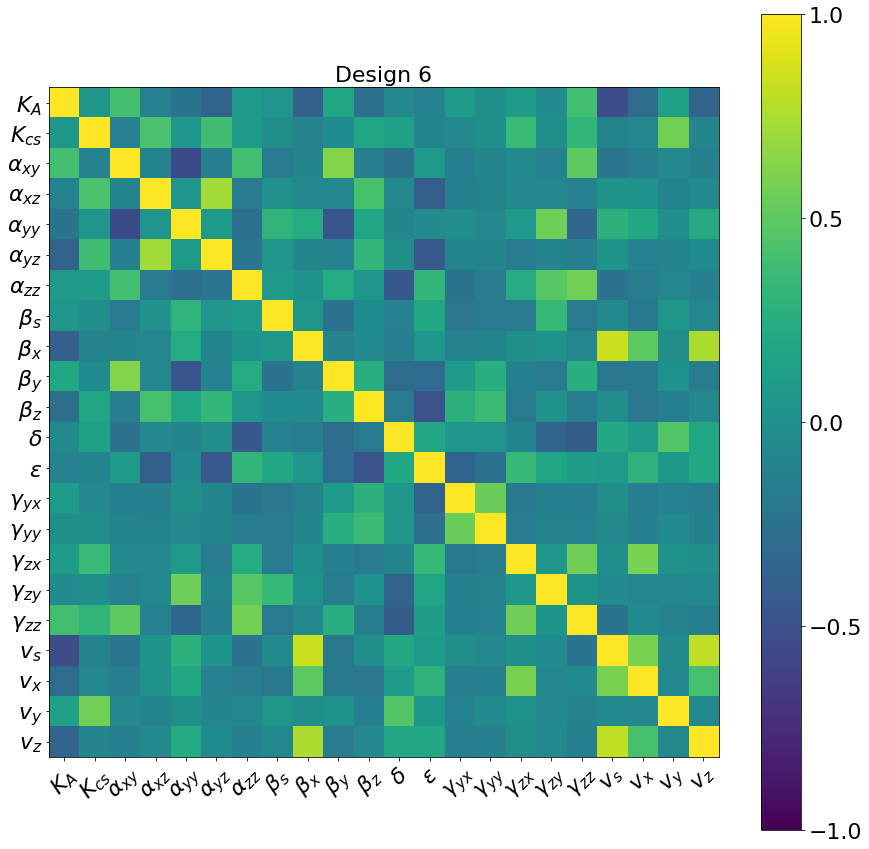

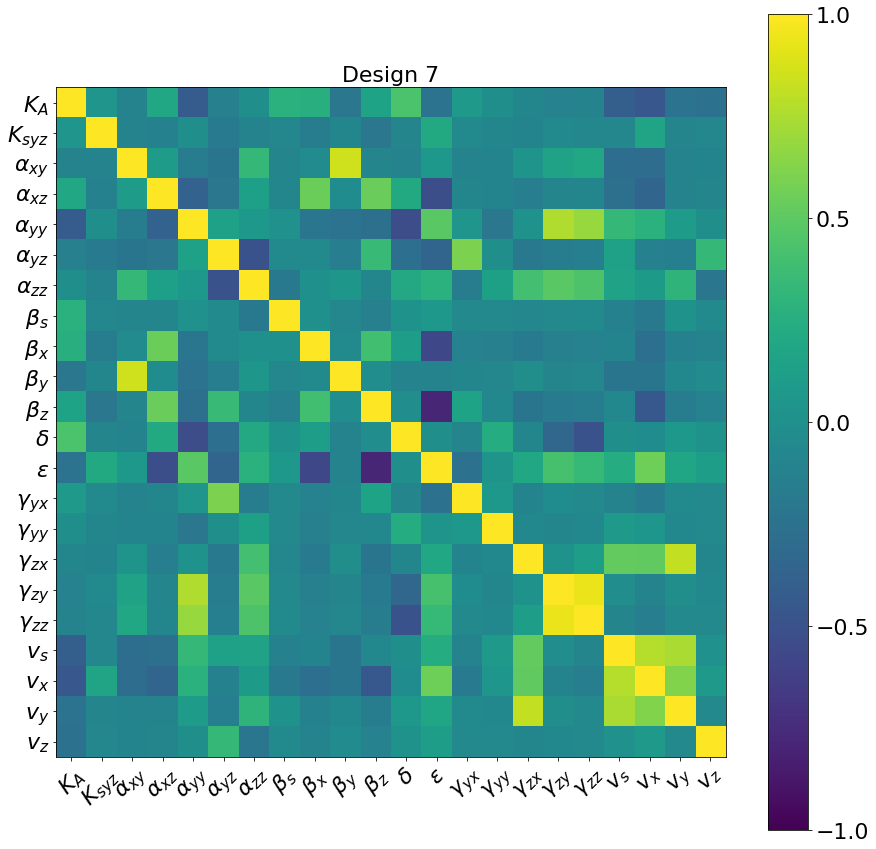

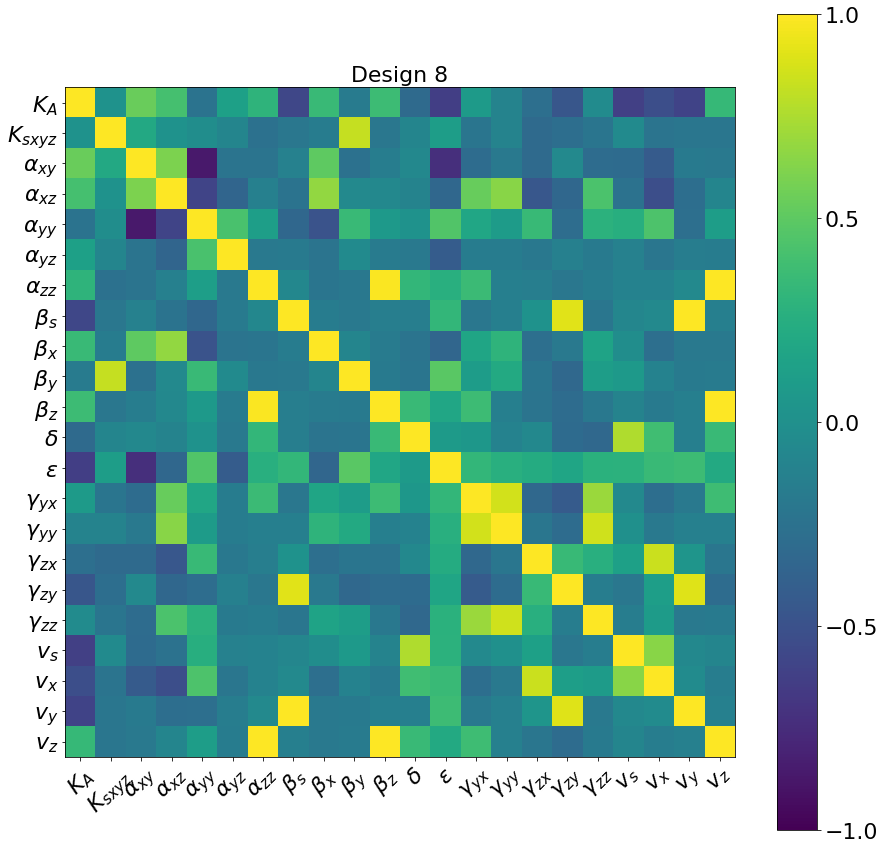

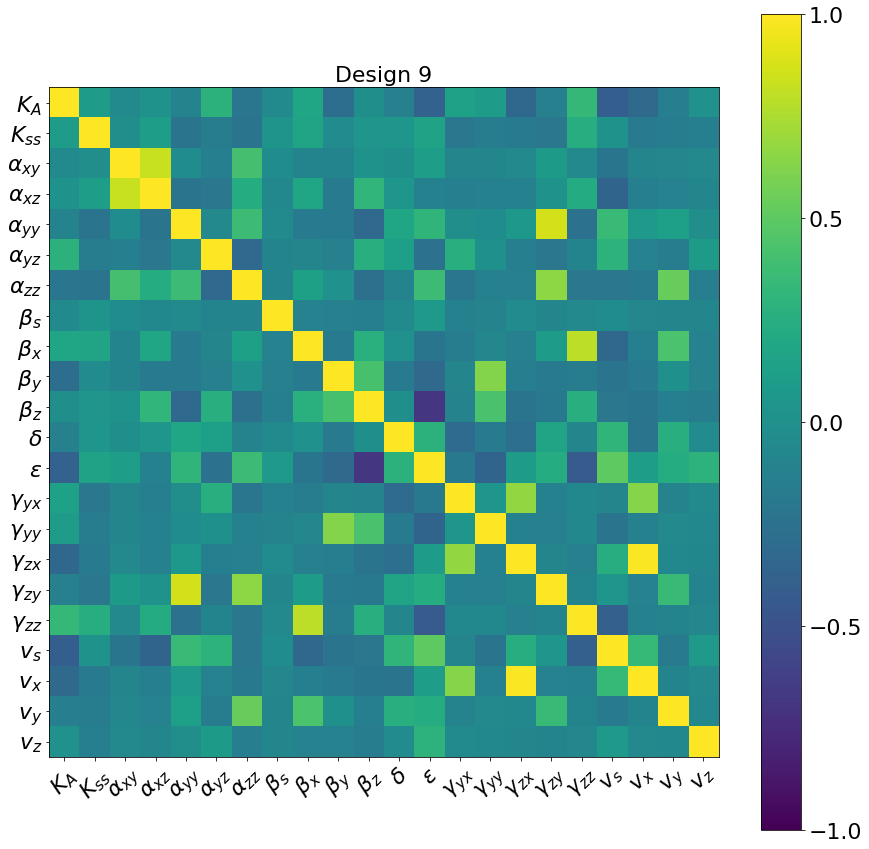

In [4]:
significance_counts = {}

all_pvals_list = {}
for j, model in enumerate(model_list):
    
    parnames = [k for k in sorted(all_pvals[model])]
    
    # turn LC parameter sets into ordered lists
    all_pvals_list[model] = [all_pvals[model][k] for k in parnames]
    
    # change parnames to latex strings for plotting
    parnames = [r'$' + p.replace('_','_{').replace('e','\\epsilon').replace('a','\\alpha').replace('g','\\gamma').replace('b','\\beta').replace('d','\\delta') for p in parnames]
    parnames = [p + '}$' if '_' in p else p+'$' for p in parnames]
    
    cc = np.corrcoef(all_pvals_list[model],)
    
    # identify the significant corelations 
    sign_corr = map(list,np.where(abs(cc) >= 0.5))
    sign_corr = list(zip(map(int,sign_corr[0]), map(int,sign_corr[1]), cc[sign_corr[0],sign_corr[1]])) # combine x and y position
    sign_corr = filter(lambda x: x[0] < x[1], sign_corr) # only the lower triangular part - the diagonal
    sign_corr = map(lambda x: (parnames[x[0]], parnames[x[1]], x[2]), sign_corr)
        
    for a,b,score in sign_corr:
        if (a,b) not in significance_counts:
            significance_counts[(a,b)] = {}
            
            significance_counts[(a,b)]['Designs'] = model[-1] # just the number
            
            if score > 0:
                significance_counts[(a,b)]['Positive correlation'] = 1
            else:
                significance_counts[(a,b)]['Negative correlation'] = 1
        else:
            
            significance_counts[(a,b)]['Designs'] += ', ' + model[-1] # just the number
            
            if score > 0:
                significance_counts[(a,b)]['Positive correlation'] += 1
            else:
                significance_counts[(a,b)]['Negative correlation'] += 1

    
    # show image
    fig = plt.figure(figsize=(15,15))
    cs = plt.imshow(cc,vmin=-1, vmax=1)
    plt.xticks(np.arange(0,len(parnames)),parnames,rotation=45)
    plt.yticks(np.arange(0,len(parnames)),parnames,rotation=0)
    cbar = plt.gcf().colorbar(cs, ticks=[1, 0.5, 0, -0.5, -1])
    fig.gca().set_title(model)
    plt.savefig('../Figures/Supp_parameter_correlations/'+model+'.png',dpi=200, bbox_inches='tight')
    plt.show()

Summarize the combinations of parameters that are often highly correlated

In [5]:
df_counts = pd.DataFrame.from_dict(significance_counts, orient='index').fillna(0)
df_counts[['Positive correlation','Negative correlation']] = df_counts[['Positive correlation','Negative correlation']].astype(int)
df_counts['Total'] = df_counts.apply(lambda row: sum(row[['Positive correlation','Negative correlation']]), axis='columns')
df_counts = df_counts.sort_values(by='Total',ascending=False)

df_summary = df_counts[df_counts['Total'] >= 3]
#df_summary.to_excel('../correlation.xlsx')
df_summary

,,Designs,Positive correlation,Negative correlation,Total
$\alpha_{yy}$,$\gamma_{zy}$,"3, 4, 5, 6, 7, 9",6,0,6
$\alpha_{xy}$,$\alpha_{xz}$,"3, 5, 8, 9",4,0,4
$v_{s}$,$v_{x}$,"3, 6, 7, 8",4,0,4
$K_{A}$,$v_{s}$,"3, 4, 6, 8",0,4,4
$\gamma_{zx}$,$v_{x}$,"6, 7, 8, 9",4,0,4
$\alpha_{xy}$,$\beta_{y}$,"3, 5, 6, 7",4,0,4
$\alpha_{xz}$,$\beta_{z}$,"3, 5, 7",3,0,3
$\beta_{z}$,$\epsilon$,"3, 7, 9",0,3,3


# Boxplots of the minimal amplitude %

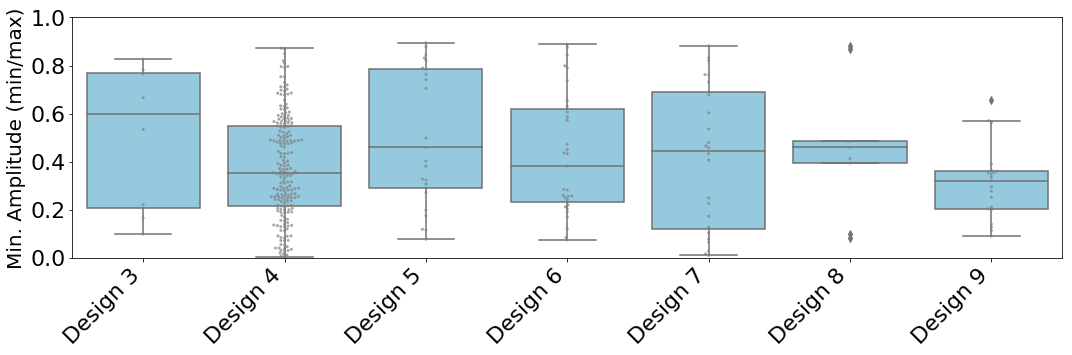

In [6]:
amplitudes = {}

df = pd.DataFrame()
for j, model in enumerate(model_list):
        
    path = '../LCs/'+model+'/LC_parameters'
    df_LC = pd.read_pickle(path)
    
    df_LC = df_LC[df_LC['Peak sequence'].isin(['s, x, y, z','x, y, z, s', 'y, z, s, x', 'z, s, x, y'])]
    
    amplitudes[model] = df_LC['Min. Amplitude (min/max)'].values.tolist()
    
amplitudes = pd.DataFrame.from_dict(amplitudes, orient='index').sort_index().T

fig = plt.figure(figsize=(15,5))

ax = sns.boxplot(data=amplitudes,color='skyblue')
ax = sns.swarmplot(data=amplitudes, color="gray", size=3, alpha=0.7)

plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylim([0,1])
fig.gca().set_ylabel('Min. Amplitude (min/max)', fontsize=20)

plt.tight_layout()
fig.savefig('../Figures/Supp_LC_properties/'+'min_amplitude.pdf')
plt.show()

In [7]:
amplitudes.mean()

Design 3    0.507657
Design 4    0.376579
Design 5    0.509389
Design 6    0.428136
Design 7    0.414095
Design 8    0.463303
Design 9    0.311184
dtype: float64

# Boxplots of the period

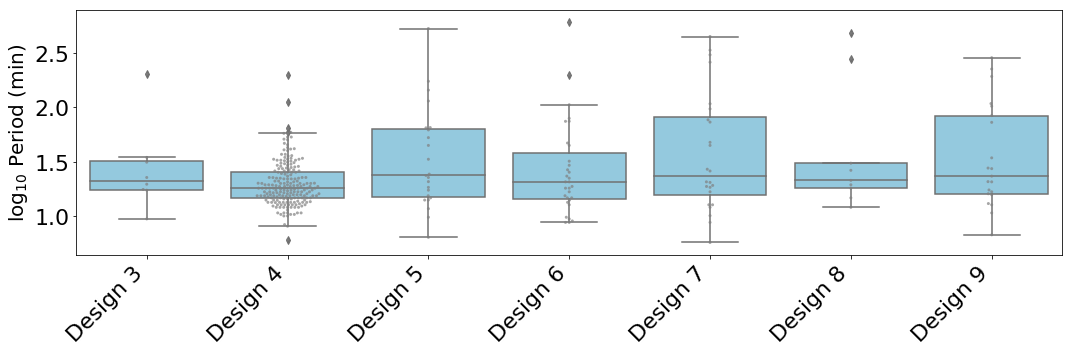

In [8]:
periods = {}

df = pd.DataFrame()
for j, model in enumerate(model_list):
        
    path = '../LCs/'+model+'/LC_parameters'
    df_LC = pd.read_pickle(path)
    
    df_LC = df_LC[df_LC['Peak sequence'].isin(['s, x, y, z','x, y, z, s', 'y, z, s, x', 'z, s, x, y'])]
    
    periods[model] = df_LC['Period'].values.tolist()
    
periods = pd.DataFrame.from_dict(periods, orient='index').sort_index().T

fig = plt.figure(figsize=(15,5))

ax = sns.boxplot(data=np.log10(periods),color='skyblue')
ax = sns.swarmplot(data=np.log10(periods), color="gray", size=3, alpha=0.7)

plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
fig.gca().set_ylabel(r'$\log_{10}$ Period (min)', fontsize=20)

plt.tight_layout()
fig.savefig('../Figures/Supp_LC_properties/'+'period.pdf')
plt.show()

In [9]:
periods.mean()

Design 3    44.449533 
Design 4    22.708508 
Design 5    65.199971 
Design 6    52.673459 
Design 7    84.398295 
Design 8    100.637989
Design 9    63.619470 
dtype: float64

# PCA 

## PCA on each model separately
Load the parameter sets that show LCs with correct peak sequences, convert the dictionary of parameters to a list of features and standardize the features. 

Then perform PCA for 2 components and plot the LC parameter sets along the components.

PCA supplies us with a lower-dimensional picture, a projection of the parametersets when viewed from the most informative viewpoint.

slice(72, 76, None)


/Users/thierry/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


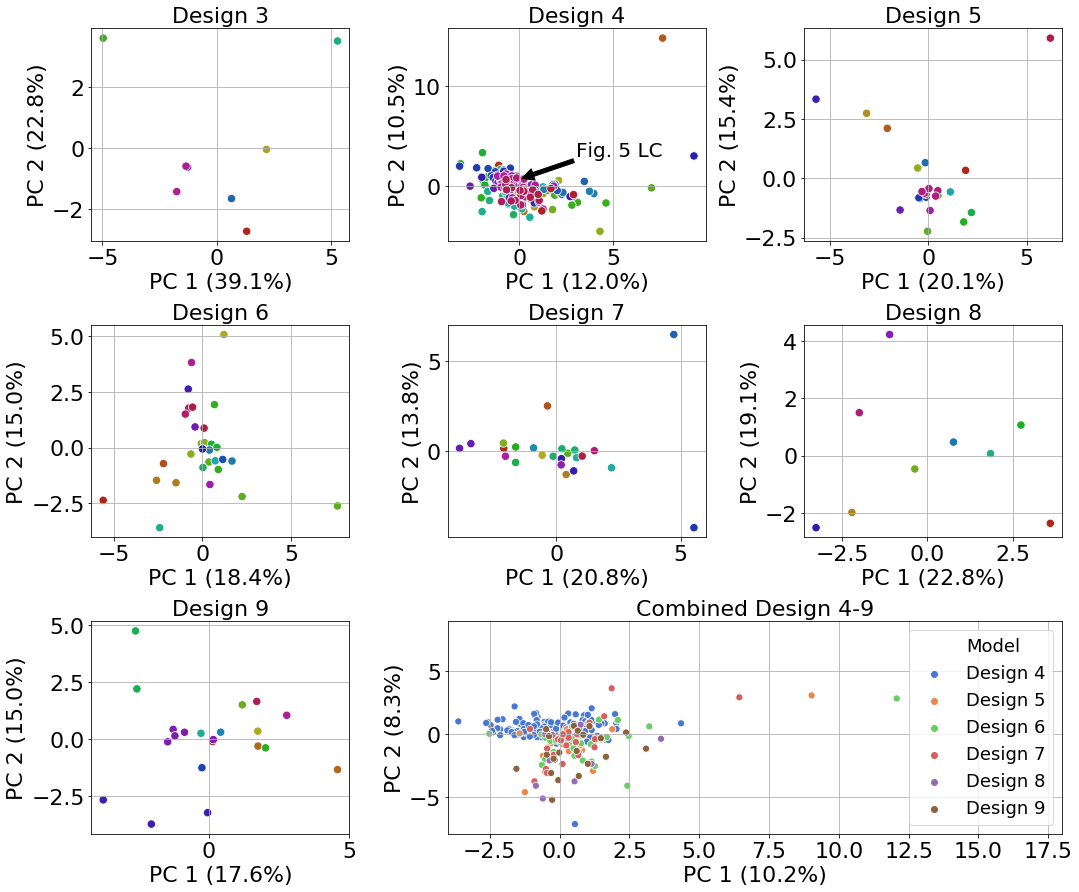

In [10]:
fig = plt.figure(figsize = (15,12.5))

for i,model in enumerate(model_list):
    path = '../LCs/'+model+'/LC_parameters'
    df = pd.read_pickle(path)
    
    df = df[df['Peak sequence'].isin(['s, x, y, z','x, y, z, s', 'y, z, s, x', 'z, s, x, y'])]
        
    if i == 1:
        print(df.index.get_loc('1906532'))
        idx_fig_5_LC = 72
        

    # Separating out the features (i.e. parameter values)
    x = df.loc[:, 'Parameters'].apply(lambda row: [row[p] for p in pnames[model]]) # series
    
    x = x.values.tolist() # list of lists

    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    # Perform PCA
    pca = PCA(n_components=20)

    principalComponents = pca.fit_transform(x)

    principalDf = pd.DataFrame(data = principalComponents[:,:2],
                 columns = ['principal component 1', 'principal component 2'])
    
    principalDf['phenotype'] = df.index.tolist()
    principalDf['phenotype'].astype(np.float)

    # Plot the principal components
    ax = plt.subplot(3,3,i+1)

    sns.scatterplot(ax=ax,x='principal component 1', y='principal component 2', hue=principalDf.phenotype.values, 
                    data=principalDf,legend=False,s=70, palette=sns.hls_palette(len(principalDf.phenotype.unique()),l=.4, s=.7))
    
    if i==1:
        # plot the Fig. 5 LC
        ax.annotate('Fig. 5 LC', xy=(0.126426, 0.759941), xytext=(3, 3),
            arrowprops=dict(facecolor='black', shrink=1), fontsize = 20)
    
    ax.grid()
    ax.set_xlabel('PC 1 ({0}%)'.format(str(round(100*pca.explained_variance_ratio_[0],1))))
    ax.set_ylabel('PC 2 ({0}%)'.format(str(round(100*pca.explained_variance_ratio_[1],1))))
    ax.set_title(model)
    
    
######## Combined plot for design 4-9

model_sublist = model_list[1:] 

all_psets = [] # a list of lists of lists
col_model = []
for i,model in enumerate(model_sublist):
    path = '../LCs/'+model+'/LC_parameters'
    df = pd.read_pickle(path)
    df = df[df['Peak sequence'].isin(['s, x, y, z','x, y, z, s', 'y, z, s, x', 'z, s, x, y'])]

    # Separating out the features
    x = df.loc[:, 'Parameters'].apply(lambda row: [row[p] for p in pnames[model]]) # series
    x = x.values.tolist() # list of lists
    
    # combine with other models
    col_model.extend([model]*len(x))
    all_psets.extend(x)
    
# Standardizing the features
all_psets = StandardScaler().fit_transform(all_psets)

# Perform PCA
pca = PCA(n_components=20)

principalComponents = pca.fit_transform(all_psets)

principalDf = pd.DataFrame(data = principalComponents[:,:2],
              columns = ['principal component 1', 'principal component 2'])

# combine with model info
col_model = pd.Series(col_model)
col_model.name = 'model'
finalDf = pd.concat([principalDf, col_model], axis = 1)

# plot
ax = plt.subplot2grid((3, 3), (2, 1), colspan=2, rowspan=1)

finalDf = finalDf.rename({'model':'Model'},axis=1)

sns.scatterplot(ax=ax, x=finalDf['principal component 1'],y=finalDf['principal component 2'],
               hue = finalDf['Model'],legend='brief',palette='muted',s=50)
ax.grid()
ax.set_xlabel('PC 1 ({0}%)'.format(str(round(100*pca.explained_variance_ratio_[0],1))))
ax.set_ylabel('PC 2 ({0}%)'.format(str(round(100*pca.explained_variance_ratio_[1],1))))
ax.set_title('Combined Design 4-9')
ax.set_xlim([-4,18])

########    

fig.tight_layout()
fig.savefig('../Figures/Figure_4_PCA_LC_parameter_sets.pdf')
fig.savefig('../Figures/Figure_4_PCA_LC_parameter_sets.png', dpi=300)

fig.show()

In [11]:
# what is PC1 in terms of the original parameters?
{pnames['Design 4'][i]:pca.components_[0][i] for i in range(len(pnames['Design 4']))}

{'K_A': -0.3674940010603019,
 'K_zx': 0.07256000424936804,
 'a_xy': -0.17056682279492172,
 'a_xz': -0.05694831822170084,
 'a_yy': 0.2760979462308,
 'a_yz': 0.08706180645532939,
 'a_zz': -0.22461859400729958,
 'b_s': 0.10705250639658491,
 'b_x': 0.33102229441128384,
 'b_y': -0.3324891998069658,
 'b_z': -0.1186497365794488,
 'd': 0.21482789357333829,
 'e': 0.028000976030206848,
 'g_yx': 0.05640409052856104,
 'g_yy': 0.012814580819109437,
 'g_zx': 0.21827289205106332,
 'g_zy': 0.13397010767344344,
 'g_zz': 0.022068309634826876,
 'v_s': 0.5377679619425373,
 'v_x': 0.11499712888935286,
 'v_y': 0.16739379169860064,
 'v_z': 0.024954132635624904}

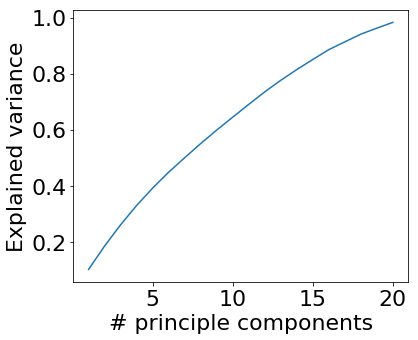

In [12]:
fig = plt.figure(figsize=(6,5))
plt.plot(np.linspace(1,20,20),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# principle components')
plt.ylabel('Explained variance')
plt.show()